In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tqdm import tqdm

In [2]:
train = pd.read_parquet("processed/final_dataset.parquet")

In [3]:
len(train)


23060846

In [4]:
def make_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df["hour"] = df["timestamp"].dt.hour
    
    periods = 20
    df["anglez"] = abs(df["anglez"])
    df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill").astype('float16')
    df["enmo_diff"] = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill").astype('float16')
    df["anglez_rolling_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_mean"] = df["enmo"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_max"] = df["anglez"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_max"] = df["enmo"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_std"] = df["anglez"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_std"] = df["enmo"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_mean"] = df["anglez_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_mean"] = df["enmo_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_max"] = df["anglez_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_max"] = df["enmo_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    
    return df

features = ["hour",
            "anglez",
            "anglez_rolling_mean",
            "anglez_rolling_max",
            "anglez_rolling_std",
            "anglez_diff",
            "anglez_diff_rolling_mean",
            "anglez_diff_rolling_max",
            "enmo",
            "enmo_rolling_mean",
            "enmo_rolling_max",
            "enmo_rolling_std",
            "enmo_diff",
            "enmo_diff_rolling_mean",
            "enmo_diff_rolling_max"]


In [5]:
train = make_features(train)

X = train[features]
y = train["awake"]
groups = train["series_id"]

/tmp/ipykernel_2866/747472510.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill").astype('float16')
/tmp/ipykernel_2866/747472510.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["enmo_diff"] = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill").astype('float16')
/tmp/ipykernel_2866/747472510.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_rolling_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
/tmp/ipykernel_2866/747472510.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a fu

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
import numpy as np
import pandas as pd

n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

oof_preds = np.zeros(len(X))
oof_preds_not_awake = np.zeros(len(X))
feature_importances = np.zeros(X.shape[1])

# Optional: speichern der Metriken pro Fold
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups)):
    print(f"\n🔁 Fold {fold + 1}")

    X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # Modell trainieren
    model = RandomForestClassifier(
        n_estimators=100,
        min_samples_leaf=300,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_tr, y_tr)

    # Vorhersagen
    probs = model.predict_proba(X_val)
    preds = model.predict(X_val)

    oof_preds[val_idx] = probs[:, 1]             # awake-Wahrscheinlichkeit
    oof_preds_not_awake[val_idx] = probs[:, 0]   # nicht-awake

    # Metriken
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    ap = average_precision_score(y_val, probs[:, 1])

    fold_metrics.append({
        'fold': fold + 1,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'average_precision': ap
    })

    print(f"📈 Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AP: {ap:.4f}")

    # Feature Importances aufsummieren
    feature_importances += model.feature_importances_

# Feature-Importance Mittelwert über Folds
avg_importances = feature_importances / n_splits
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': avg_importances
}).sort_values(by='importance', ascending=False)

# Metriken zusammenfassen
metrics_df = pd.DataFrame(fold_metrics)
print("\n📊 Fold-wise metrics:\n", metrics_df)
print(f"\n🔍 Mean Average Precision: {metrics_df['average_precision'].mean():.4f}")

print("\n🔥 Feature Importances:\n", importance_df)


🔁 Fold 1
📈 Precision: 0.9743 | Recall: 0.9596 | F1: 0.9669 | AP: 0.9944

🔁 Fold 2
📈 Precision: 0.9787 | Recall: 0.9580 | F1: 0.9682 | AP: 0.9939

🔁 Fold 3
📈 Precision: 0.9701 | Recall: 0.9700 | F1: 0.9700 | AP: 0.9949

🔁 Fold 4
📈 Precision: 0.9708 | Recall: 0.9661 | F1: 0.9684 | AP: 0.9950

🔁 Fold 5
📈 Precision: 0.9762 | Recall: 0.9534 | F1: 0.9646 | AP: 0.9936

📊 Fold-wise metrics:
    fold  precision    recall  f1_score  average_precision
0     1   0.974266  0.959600  0.966878           0.994445
1     2   0.978711  0.957973  0.968231           0.993853
2     3   0.970145  0.969954  0.970049           0.994878
3     4   0.970787  0.966078  0.968427           0.994986
4     5   0.976156  0.953411  0.964649           0.993578

🔍 Mean Average Precision: 0.9943

🔥 Feature Importances:
                      feature  importance
4         anglez_rolling_std    0.191679
0                       hour    0.184989
14     enmo_diff_rolling_max    0.147039
11          enmo_rolling_std    0.137997


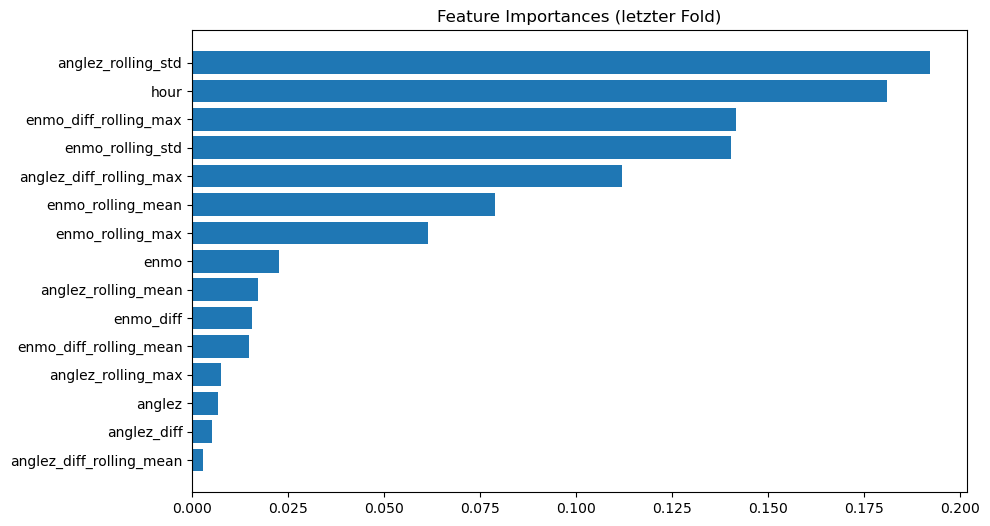

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
# Nur einmalig am Ende des letzten Folds oder außerhalb der Schleife
importances = model.feature_importances_
feature_names = X.columns  # oder X_train.columns

# In DataFrame
feat_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Anzeige
plt.figure(figsize=(10, 6))
plt.barh(feat_df["feature"], feat_df["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importances (letzter Fold)")
plt.show()

In [8]:
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

NameError: name 'feat_imp' is not defined

<Figure size 1000x600 with 0 Axes>

In [9]:



train["awake"] = oof_preds
train["not_awake"] = oof_preds_not_awake


# Smoothing the predictions
smoothing_length = 2*230
train["score"]  = train["awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")
train["smooth"] = train["not_awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")

# Re-binarize the smooth values
train["smooth"] = train["smooth"].round()

/tmp/ipykernel_2866/1157157083.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train["score"]  = train["awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")
/tmp/ipykernel_2866/1157157083.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train["smooth"] = train["not_awake"].rolling(smoothing_length,center=True).mean().fillna(method="bfill").fillna(method="ffill")


In [10]:

# Define the function to determine the onset and wakeup events
def get_event(df):
    lstCV = zip(df.series_id, df.smooth)
    lstPOI = []
    for (c, v), g in groupby(lstCV, lambda cv: (cv[0], cv[1] != 0 and not pd.isnull(cv[1]))):
        llg = sum(1 for item in g)
        if v is False:
            lstPOI.extend([0] * llg)
        else:
            lstPOI.extend(['onset'] + (llg - 2) * [0] + ['wakeup'] if llg > 1 else [0])
    return lstPOI


In [11]:
from itertools import groupby

In [12]:

train["event"] = get_event(train)

# Save the events for inspection
train_events = train.loc[train["event"] != 0][["series_id", "step", "event", "score"]].copy().reset_index(drop=True)
train_events.to_csv('result_events.csv', index=False)

print("\n✅ Sleep events for training data saved under: result_events.csv")


✅ Sleep events for training data saved under: result_events.csv


In [13]:
import pandas as pd

# Load the train events CSV file into a DataFrame
train_events = pd.read_csv('result_events.csv')

# Display the first few rows to check the data
print(train_events.head(30))

       series_id    step   event     score
0   08db4255286f    9249   onset  0.498496
1   08db4255286f   14425  wakeup  0.499100
2   08db4255286f   26519   onset  0.498879
3   08db4255286f   27925  wakeup  0.499626
4   08db4255286f   28075   onset  0.499313
5   08db4255286f   31347  wakeup  0.498785
6   08db4255286f   44161   onset  0.499667
7   08db4255286f   49111  wakeup  0.499890
8   08db4255286f   60301   onset  0.498486
9   08db4255286f   66363  wakeup  0.498280
10  08db4255286f   79142   onset  0.498899
11  08db4255286f   85342  wakeup  0.497954
12  08db4255286f   97975   onset  0.499361
13  08db4255286f   98300  wakeup  0.498870
14  08db4255286f   98637   onset  0.499851
15  08db4255286f  104083  wakeup  0.499836
16  08db4255286f  114162   onset  0.498551
17  08db4255286f  118832  wakeup  0.499912
18  08db4255286f  130529   onset  0.498423
19  08db4255286f  136302  wakeup  0.498106
20  08db4255286f  147508   onset  0.499130
21  08db4255286f  153418  wakeup  0.498553
22  08db425

In [14]:
df = pd.DataFrame(train_events)

# Set a threshold for valid pairings (step difference > 15000 is invalid)
step_diff_min_threshold = 2000

# Sort by series_id and step
df = df.sort_values(by=['series_id', 'step'])

# Initialize a list to store valid event pairs
valid_pairs = []

# Iterate through each unique series_id and match onsets and wakeups
for series_id in df['series_id'].unique():
    series_data = df[df['series_id'] == series_id]
    
    onset_event = None
    for index, row in series_data.iterrows():
        if row['event'] == 'onset':
            onset_event = row
        elif row['event'] == 'wakeup' and onset_event is not None:
            # Ensure the step difference between onset and wakeup is above the minimum threshold
            step_diff = abs(row['step'] - onset_event['step'])
            if step_diff >= step_diff_min_threshold:
                valid_pairs.append((onset_event, row))  # Add the valid pair
            onset_event = None  # Reset for next pairing

# Create a DataFrame for the valid pairs in the required format
output_data = []
for onset, wakeup in valid_pairs:
    output_data.append({
        'series_id': onset['series_id'],
        'step': onset['step'],
        'event': 'onset',
        'score': onset['score']
    })
    output_data.append({
        'series_id': wakeup['series_id'],
        'step': wakeup['step'],
        'event': 'wakeup',
        'score': wakeup['score']
    })

# Create a DataFrame from the output data
output_df = pd.DataFrame(output_data)

# Save the results to a CSV file
output_df.to_csv('valid_pairs_predictions.csv', index=False)

print("Results saved to 'valid_pairs_predictions.csv'.")

Results saved to 'valid_pairs_predictions.csv'.


In [15]:
from event_detection_ap import score, ParticipantVisibleError

In [16]:
import pandas as pd


# Load ground truth and predictions
solution = pd.read_csv('processed/event_cleaned_final.csv')             # Ground truth
submission = pd.read_csv('valid_pairs_predictions.csv')                      # Your predictions from train set

# Define tolerances
tolerances = {
    "onset":  [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
    "wakeup": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
}

# Set correct column names used in your prediction file
column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score',  # You named the prediction confidence 'score'
}

# Run scoring
try:
    ap_score = score(solution, submission, tolerances, **column_names)
    print(f"\n✅ Average Precision Score: {ap_score}")
except ParticipantVisibleError as e:
    print(f"\n❌ Error: {e}")


✅ Average Precision Score: 0.4431465493999837


In [17]:
solution = pd.read_csv('processed/event_cleaned_final.csv')
submission = pd.read_csv('valid_pairs_predictions.csv')

# Function to count events per series_id
def count_events(df, label):
    counts = df[df["event"].isin(["onset", "wakeup"])] \
                .groupby(["series_id", "event"]) \
                .size() \
                .unstack(fill_value=0) \
                .reset_index()
    counts["source"] = label
    return counts

# Apply to both datasets
solution_counts = count_events(solution, "ground_truth")
submission_counts = count_events(submission, "prediction")

# Summary
print(f"🔍 Ground Truth: {solution['series_id'].nunique()} series_ids")
print(f"🔍 Predictions : {submission['series_id'].nunique()} series_ids\n")

print("📊 Ground Truth Event Counts:")
print(solution_counts.head(50))

print("\n📊 Prediction Event Counts:")
print(submission_counts.head(50))

🔍 Ground Truth: 62 series_ids
🔍 Predictions : 62 series_ids

📊 Ground Truth Event Counts:
event     series_id  onset  wakeup        source
0      08db4255286f     25      25  ground_truth
1      0a96f4993bd7     15      15  ground_truth
2      0cfc06c129cc     21      21  ground_truth
3      0ef7d94fde99     21      21  ground_truth
4      1087d7b0ff2e     24      24  ground_truth
5      10f8bc1f7b07     23      23  ground_truth
6      1319a1935f48     33      33  ground_truth
7      1716cd4163b2     25      25  ground_truth
8      18b61dd5aae8     29      29  ground_truth
9      1955d568d987     29      29  ground_truth
10     2654a87be968      8       8  ground_truth
11     29c75c018220     26      26  ground_truth
12     3452b878e596     31      31  ground_truth
13     3664fe9233f9     22      22  ground_truth
14     483d6545417f     17      17  ground_truth
15     55a47ff9dc8a     23      23  ground_truth
16     5acc9d63b5fd     24      24  ground_truth
17     5c55a5e717d6     21  